In [1]:
import numpy
import xarray
import glob
import pandas
import cartopy
import itertools
import matplotlib
import cmocean
import netCDF4
import datetime
import cftime

import matplotlib.pyplot as mp

mp.rcParams.update({'mathtext.default': 'regular'})
%matplotlib inline

In [2]:
# PRECT_orig = '/scratch/blangenb/NCAR_LENS/PRECT/b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.04020101-04991231.nc'
PRECT_orig = '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PRECC/b.e11.B1850C5CN.f09_g16.005.cam.h0.PRECC.040001-049912.nc'
PRECT_orig_ds = xarray.open_dataset(PRECT_orig)
lat_full = PRECT_orig_ds['lat'].values
lon_full = PRECT_orig_ds['lon'].values

In [119]:
#PRECT_root = '/ninad/NCAR_LENS/PRECT/'
PRECC_root = '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PRECC/'
PRECL_root = '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PRECL/'
#PRECT_root = '/scratch/blangenb/NCAR_LENS/PRECT_lonslices/'
#PRECT_root =  '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PRECT/'

In [4]:
pic_file_list_PRECC = numpy.array(sorted(glob.glob(PRECC_root+'/b.e11.B1850C5CN.f09_g16.*.nc')))
pic_file_list_PRECL = numpy.array(sorted(glob.glob(PRECL_root+'/b.e11.B1850C5CN.f09_g16.*.nc')))

In [120]:
rcp_file_list_PRECC = numpy.array(sorted(glob.glob(PRECC_root+'/b.e11.BRCP85C5CNBDRD.f09_g16.*.nc')))
rcp_file_list_PRECL = numpy.array(sorted(glob.glob(PRECL_root+'/b.e11.BRCP85C5CNBDRD.f09_g16.*.nc')))

# open pic files

In [6]:
PRECC_pic_mfds = xarray.open_mfdataset(pic_file_list_PRECC, decode_times=False)
PRECL_pic_mfds = xarray.open_mfdataset(pic_file_list_PRECL, decode_times=False)

In [7]:
PRECT_pic = (PRECC_pic_mfds['PRECC']+PRECL_pic_mfds['PRECL']).values*86400.*1000.

In [289]:
pic_time_datetime = numpy.array([cftime.DatetimeNoLeap(year,month,1) \
                                 for year,month in itertools.product(range(400,2201), range(1, 13))])

doing seasonal means for now

In [318]:
#SEAS_list = [10,11,12,1,2,3]; time_seas_indices = [d.month in SEAS_list for d in pic_time_datetime]; SEAS_name = 'ONDJFM'
#SEAS_list = [4,5,6,7,8,9]; time_seas_indices = [d.month in SEAS_list for d in pic_time_datetime]; SEAS_name = 'AMJJAS'
SEAS_list = [12,1,2]; time_seas_indices = [d.month in SEAS_list for d in pic_time_datetime]; SEAS_name = 'DJF'
time_seas_datetime = pic_time_datetime[time_seas_indices]

In [319]:
# take seasonal means of data set
pic_nyears = pic_time_datetime[-1].year - pic_time_datetime[0].year
pic_year_start = pic_time_datetime[0].year
pic_year_end = pic_time_datetime[-1].year
pic_year_array = numpy.arange(pic_year_start, pic_year_start+pic_nyears, dtype=numpy.int)

PRECT_pic_seas_means = numpy.zeros((pic_nyears, PRECT_pic.shape[1], PRECT_pic.shape[2]))
for y,current_year in enumerate(pic_year_array):
    if y%100==0:
        print(current_year)
    year_seas_indices = [(d.month in SEAS_list) and (d.year==current_year) for d in pic_time_datetime]
    PRECT_pic_seas_means[y,:,:] = numpy.mean(PRECT_pic[year_seas_indices,:,:], axis=0)

400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


In [320]:
return_period = 100 # in years

In [321]:
events_per_year = 1
return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

pic_hi_percentile_values = numpy.zeros((lat_full.size,lon_full.size))
for j in range(lat_full.size):
    for k in range(lon_full.size):
        tmp_distro = PRECT_pic_seas_means[:,j,k]
        pic_hi_percentile_values[j,k] = numpy.percentile(tmp_distro, return_val_perc)

99.0


In [322]:
events_per_year = 1
return_val_perc = 100*(1/(return_period*events_per_year))
print(return_val_perc)

pic_lo_percentile_values = numpy.zeros((lat_full.size,lon_full.size))
for j in range(lat_full.size):
    for k in range(lon_full.size):
        tmp_distro = PRECT_pic_seas_means[:,j,k]
        pic_lo_percentile_values[j,k] = numpy.percentile(tmp_distro, return_val_perc)

1.0


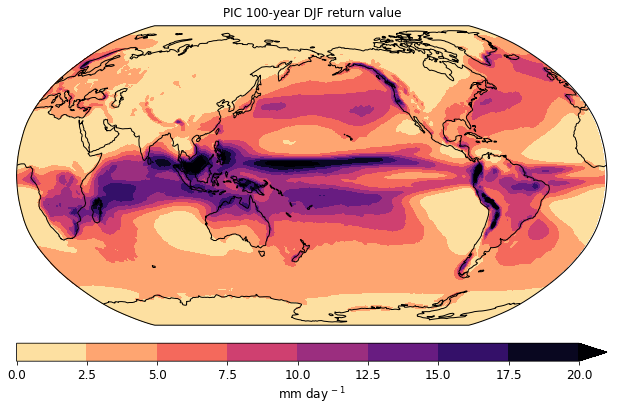

In [323]:
fontsize=12

map_proj = cartopy.crs.Robinson(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='PIC 100-year '+SEAS_name+' return value', x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,21,2.5)
plot = ax.contourf(lon_full, lat_full, pic_hi_percentile_values, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap='magma_r', extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

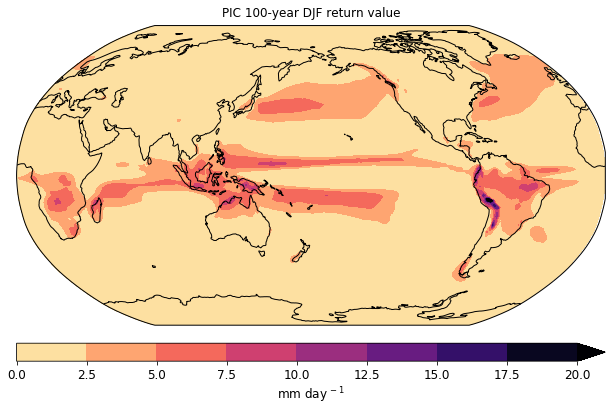

In [324]:
fontsize=12

map_proj = cartopy.crs.Robinson(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='PIC 100-year '+SEAS_name+' return value', x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,21,2.5)
plot = ax.contourf(lon_full, lat_full, pic_lo_percentile_values, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap='magma_r', extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

import all historical data sets

In [325]:
# define member strings for hist/rcp
multifile_members = ['{:03d}'.format(i) for i in range(1,34)]
all_members = ['{:03d}'.format(i) for i in range(1,36)] + ['{:03d}'.format(i) for i in range(101,106)]

In [326]:
rcp_time_datetime = numpy.array([cftime.DatetimeNoLeap(year,month,1) \
                                 for year,month in itertools.product(range(2006,2101), range(1,13))])

In [327]:
rcp_start = cftime.DatetimeNoLeap(2070,1,1)
rcp_end = cftime.DatetimeNoLeap(2099,12,31)
rcp_time_indices = list(numpy.where((rcp_time_datetime>=rcp_start)&(rcp_time_datetime<=rcp_end))[0])

In [328]:
rcp_nyears = 30
rcp_year_array = numpy.arange(rcp_start.year, rcp_end.year+1, dtype=numpy.int)
rcp_time_datetime_subset = rcp_time_datetime[rcp_time_indices]

In [329]:
PRECT_all_rcp_data = numpy.zeros((all_members.__len__(), rcp_nyears*12, lat_full.size, lon_full.size))

In [330]:
# do all this for the first lon box to get the time and lat/lon information
member_idx = 0
for member_idx in range(40):
    
    which_member = all_members[member_idx]
    print(which_member)

    PRECC_file_indices = [file.split('/')[-1].split('.')[4]==which_member for file in rcp_file_list_PRECC]
    PRECL_file_indices = [file.split('/')[-1].split('.')[4]==which_member for file in rcp_file_list_PRECL]

    PRECC_member_file_list = rcp_file_list_PRECC[PRECC_file_indices]
    PRECL_member_file_list = rcp_file_list_PRECL[PRECL_file_indices]

    if PRECC_member_file_list.__len__()!=PRECL_member_file_list.__len__():
        print('weird not same length')
    elif PRECC_member_file_list.__len__()>1:
        PRECC_rcp_ds = xarray.open_mfdataset(PRECC_member_file_list)
        PRECL_rcp_ds = xarray.open_mfdataset(PRECL_member_file_list)
    else:
        PRECC_rcp_ds = xarray.open_dataset(PRECC_member_file_list[0])
        PRECL_rcp_ds = xarray.open_dataset(PRECL_member_file_list[0])

    # prect_rcp = prect_rcp_ds['PRECT']*86400.*1000.

    PRECT_rcp_ds = (PRECC_rcp_ds['PRECC']+PRECL_rcp_ds['PRECL']).isel(time=rcp_time_indices)
    
    PRECT_all_rcp_data[member_idx,:,:,:] = PRECT_rcp_ds.values*86400.*1000.


001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


take seasonal means of hist

In [331]:
PRECT_rcp_seas_means = numpy.zeros((all_members.__len__(), rcp_nyears, lat_full.size, lon_full.size))

for member_idx in range(40):
    print(all_members[member_idx])
    for y,current_year in enumerate(rcp_year_array):
        year_seas_indices = [(d.month in SEAS_list) and (d.year==current_year) for d in rcp_time_datetime_subset]
        PRECT_rcp_seas_means[member_idx,y,:,:] = numpy.mean(PRECT_all_rcp_data[member_idx,year_seas_indices,:,:], axis=0)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


In [332]:
PRECT_rcp_exceedance_counts = numpy.zeros((lat_full.size, lon_full.size))

for j in range(lat_full.size):
    for k in range(lon_full.size):
        PRECT_rcp_exceedance_counts[j,k] = numpy.sum(PRECT_rcp_seas_means[:,:,j,k]>pic_hi_percentile_values[j,k])

In [333]:
PRECT_rcp_deceedance_counts = numpy.zeros((lat_full.size, lon_full.size))

for j in range(lat_full.size):
    for k in range(lon_full.size):
        PRECT_rcp_deceedance_counts[j,k] = numpy.sum(PRECT_rcp_seas_means[:,:,j,k]<pic_lo_percentile_values[j,k])

In [334]:
PRECT_rcp_normalized_exceedances = PRECT_rcp_exceedance_counts/(30*40)/((pic_nyears/return_period)/pic_nyears)
PRECT_rcp_normalized_deceedances = PRECT_rcp_deceedance_counts/(30*40)/((pic_nyears/return_period)/pic_nyears)

In [335]:
# make color map
minval=0.0 # 
maxval=0.95 #
n=256
full_cmap = cmocean.cm.balance_r #mp.get_cmap('RdBu')
full_cmap_r = cmocean.cm.balance
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))
cmap_partial_r = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap_r.name, a=minval, b=maxval), full_cmap_r(numpy.linspace(minval, maxval, n)))

In [336]:
#clevels = numpy.hstack((numpy.arange(0,1.1,0.1), numpy.arange(5,50.1,5)))
clevels = numpy.hstack((numpy.arange(0,1.1,0.1), numpy.array([2,3,4,5,10,15,20,30,50,100])))
bounds = clevels
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

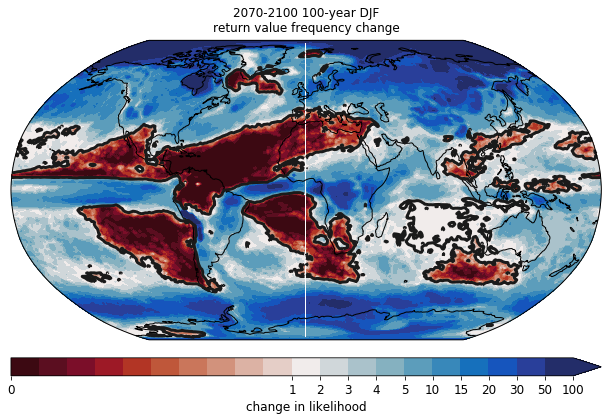

In [337]:
fontsize=12

map_proj = cartopy.crs.Robinson(central_longitude=0)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='2070-2100 100-year '+SEAS_name+'\nreturn value frequency change', \
        x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
        transform=ax.transAxes)

plot = ax.contourf(lon_full, lat_full, PRECT_rcp_normalized_exceedances, \
                   levels=clevels, \
                   transform=data_proj, extend='max', \
                   cmap=cmap_partial, norm=norm)

plot_one = ax.contour(lon_full, lat_full, PRECT_rcp_normalized_exceedances, \
                      levels=[1.0], linewidths=[3], colors=['0.1'], transform=data_proj)

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_ticks([0,1,2,3,4,5,10,15,20,30,50,100])
cbar.set_label('change in likelihood', fontsize=fontsize)

In [339]:
fontsize=12

map_proj = cartopy.crs.Robinson(central_longitude=0)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='2070-2100 100-year '+SEAS_name+'\nreturn value frequency change', \
        x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
        transform=ax.transAxes)

plot = ax.contourf(lon_full, lat_full, PRECT_rcp_normalized_deceedances, \
                   levels=clevels, \
                   transform=data_proj, extend='max', \
                   cmap=cmap_partial_r, norm=norm)

plot_one = ax.contour(lon_full, lat_full, PRECT_rcp_normalized_deceedances, \
                      levels=[1.0], linewidths=[3], colors=['0.1'], transform=data_proj)

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_ticks([0,1,2,3,4,5,10,15,20,30,50,100])
cbar.set_label('change in likelihood', fontsize=fontsize)

TopologyException: side location conflict at 46.25 24.031413612565444


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x2aac2838d2b0>

TopologyException: side location conflict at 46.25 24.031413612565444


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2aaaec61f9d8> (for post_execute):


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x2aac602e6cf8>

TopologyException: side location conflict at 46.25 24.031413612565444


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x2aac2838dc18>

<Figure size 612x360 with 1 Axes>

In [340]:
sign_switch_regions = numpy.array((PRECT_rcp_normalized_deceedances>1)&(PRECT_rcp_normalized_exceedances>1), dtype=numpy.float)
sign_switch_regions[sign_switch_regions==0]=numpy.nan

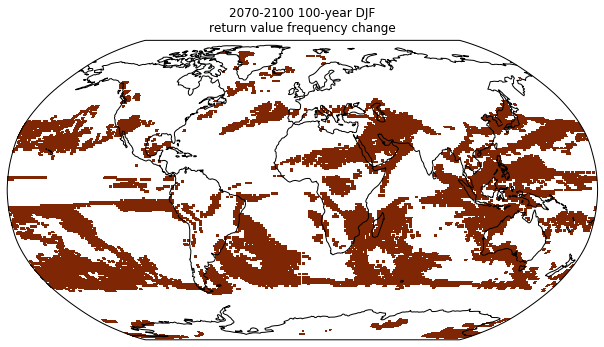

In [342]:
fontsize=12

map_proj = cartopy.crs.Robinson(central_longitude=0)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='2070-2100 100-year '+SEAS_name+'\nreturn value frequency change', \
        x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
        transform=ax.transAxes)

plot = ax.pcolormesh(lon_full, lat_full, sign_switch_regions, \
                    #levels=clevels, \
                    transform=data_proj, \
                    cmap='Oranges', vmin=0, vmax=1)

# plot_one = ax.contour(lon_full, lat_full, PRECT_rcp_normalized_deceedances, \
#                       levels=[1.0], linewidths=[3], colors=['0.1'], transform=data_proj)

fig.tight_layout()

# axpos = ax.get_position()
# cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
# cbar_ax.tick_params(labelsize=fontsize)

# cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_ticks([0,1,2,3,4,5,10,15,20,30,50,100])
# cbar.set_label('switch sign', fontsize=fontsize)